In [2]:
from util.io.ffr import *
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy import signal
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

In [3]:
def read_epochs(BIDS_ROOT, sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    from bids import BIDSLayout
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [4]:
def compute_spectrum_dB(epo):
    import numpy
    '''
    Computes power spectrum of frequency following response
    '''
    # assert(epo.tmin == -epo.tmax)
    TMAX = abs(epo.tmin)
    poststim = epo.average().compute_psd(tmin = 0., tmax = TMAX)
    baseline = epo.average().compute_psd(tmin = epo.tmin, tmax = 0.)
    power = 10 * numpy.log10(poststim.get_data() / baseline.get_data())
    power = numpy.squeeze(power)
    return poststim.freqs, power

In [5]:
# # Look at FFR by target tone identity
# BIDS_ROOT = '../data/bids'
# layout = BIDSLayout(BIDS_ROOT, derivatives = True)
# subs = layout.get_subjects(scope = 'preprocess_ffr')
# subs.sort(key = int)
# spectrums = []
# conditions = ['11', '12', '13', '21', '22', '23', '31', '32', '33']
# stim_dict = {'1': 130,
#              '2': 200,
#              '3': 280}

# for sub in subs:
#     print(sub)
        
#     # Read epochs object
#     epochs = read_epochs(sub, 'forFFR')

#     # Iterate over conditions
#     for condition in conditions:
#         print(f'target: {stim_dict[condition[0]]}')
#         print(f'stimulus: {stim_dict[condition[1]]}')
        
#         # Compute power in dB
#         freqs, power = compute_spectrum_dB(epochs[condition])
#         df = pd.DataFrame(
#             {'subject': sub,
#              'target': stim_dict[condition[0]],
#              'stimulus': stim_dict[condition[1]],
#              'frequency': poststim.freqs,
#              'power': power
#             }
#         )
#         spectrums.append(df)
    
# # Create dataframe and save
# spectrums = pd.concat(spectrums)
# spectrums.to_csv('spectrums.csv', index = False)
spectrums = pd.read_csv('spectrums.csv')

In [6]:
palette_tab10 = sns.color_palette("tab10", 10)

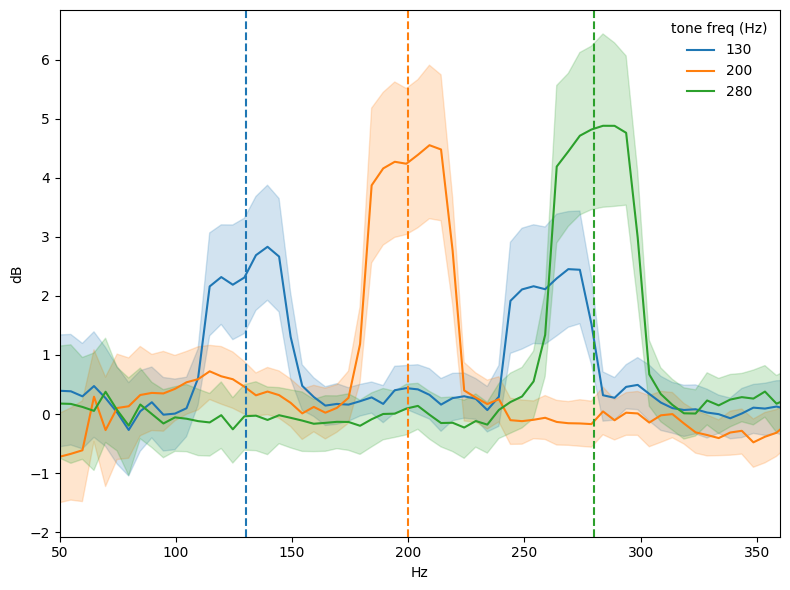

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
spectrums_sub = spectrums.groupby(['subject', 'stimulus', 'frequency'], as_index=False)['power'].mean()
graph = sns.lineplot(data = spectrums_sub, x = "frequency", y = "power", hue = "stimulus", palette = 'tab10', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(200, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(280, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 360)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
# plt.savefig('../figs/FFR.png')

### By target

In [8]:
spectrums_sub = spectrums.groupby(['subject', 'stimulus', 'frequency', 'target'], as_index=False)['power'].mean()

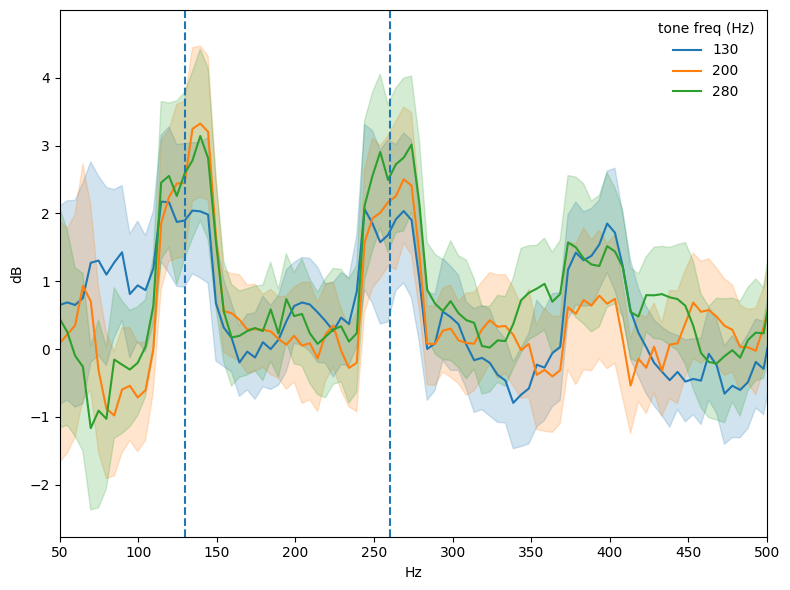

In [9]:
spectrums_tone = spectrums_sub[spectrums_sub.stimulus == 130]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = spectrums_tone, x = "frequency", y = "power", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(260, linestyle = 'dashed', color = palette_tab10[0])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 500)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
# plt.savefig('../figs/FFR.png')

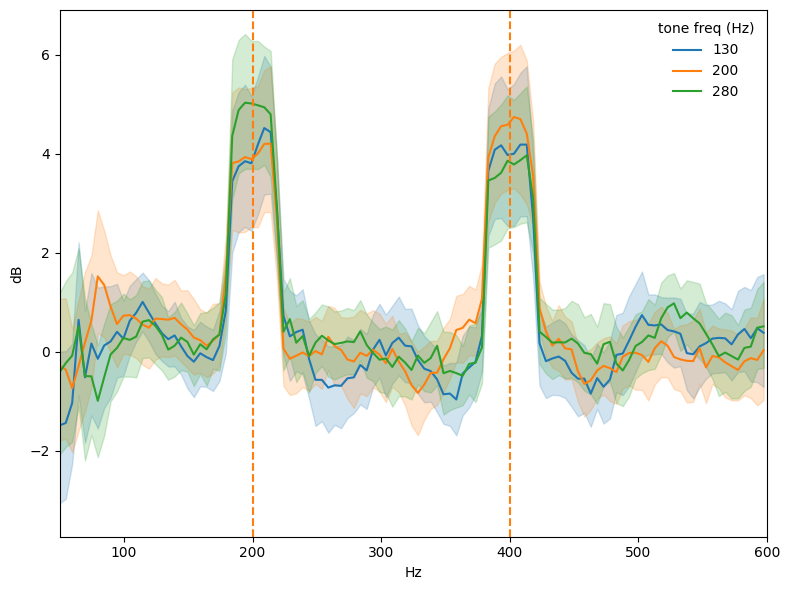

In [10]:
spectrums_tone = spectrums_sub[spectrums_sub.stimulus == 200]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = spectrums_tone, x = "frequency", y = "power", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(200, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(400, linestyle = 'dashed', color = palette_tab10[1])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 600)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
# plt.savefig('../figs/FFR.png')

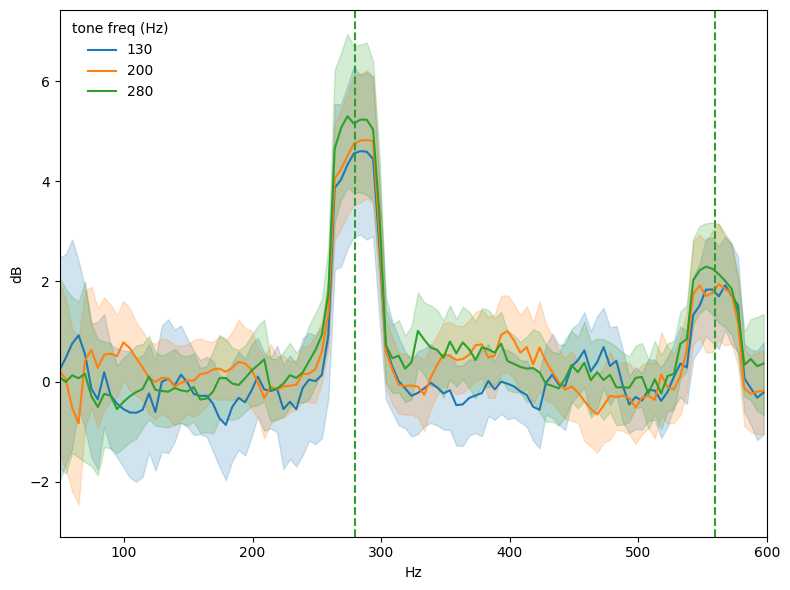

In [11]:
spectrums_tone = spectrums_sub[spectrums_sub.stimulus == 280]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = spectrums_tone, x = "frequency", y = "power", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(280, linestyle = 'dashed', color = palette_tab10[2])
graph.axvline(560, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 600)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
# plt.savefig('../figs/FFR.png')

### Values and tests

In [60]:
power_f0 = pd.DataFrame()
stimuli = [130, 200, 280]
for stim in stimuli:
    idx = np.abs(spectrums_sub.frequency - stim).argmin()
    hz = spectrums_sub.frequency[idx]
    stim_spectrum = spectrums_sub[spectrums_sub.frequency == hz]
    power_f0 = pd.concat([power_f0, stim_spectrum])
    # break
power_f0 = power_f0.reset_index(drop = True)
power_f0.to_csv('power_f0.csv', index = False)
power_f0 = pd.read_csv('power_f0.csv')
power_f0

,subject,stimulus,frequency,target,power
0,3,130,129.460581,130,2.126778
1,3,130,129.460581,200,7.821449
2,3,130,129.460581,280,6.387437
3,3,200,129.460581,130,1.704627
4,3,200,129.460581,200,-0.821581
...,...,...,...,...,...
1129,45,200,278.838174,200,-1.281757
1130,45,200,278.838174,280,0.492988
1131,45,280,278.838174,130,-0.807070
1132,45,280,278.838174,200,1.511245


(-5.0, 10.0)

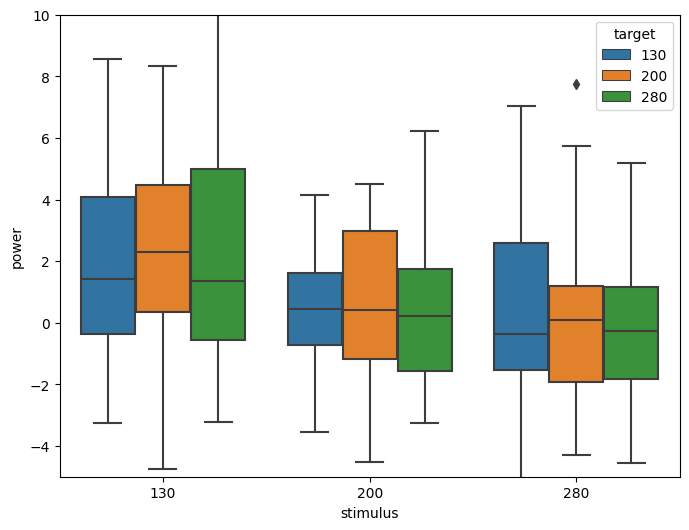

In [69]:
tmp = power_f0[(power_f0.frequency < 130) & (power_f0.frequency > 129)]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.boxplot(tmp, x = 'stimulus', y = 'power', hue = 'target', ax = ax)
graph.set_ylim(-5, 10)

(-5.0, 15.0)

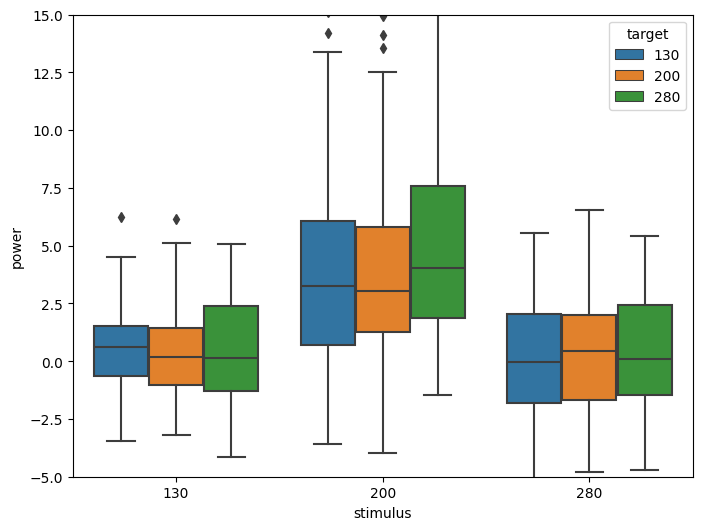

In [64]:
tmp = power_f0[(power_f0.frequency < 200) & (power_f0.frequency > 199)]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.boxplot(tmp, x = 'stimulus', y = 'power', hue = 'target', ax = ax)
graph.set_ylim(-5, 15)

(-7.0, 15.0)

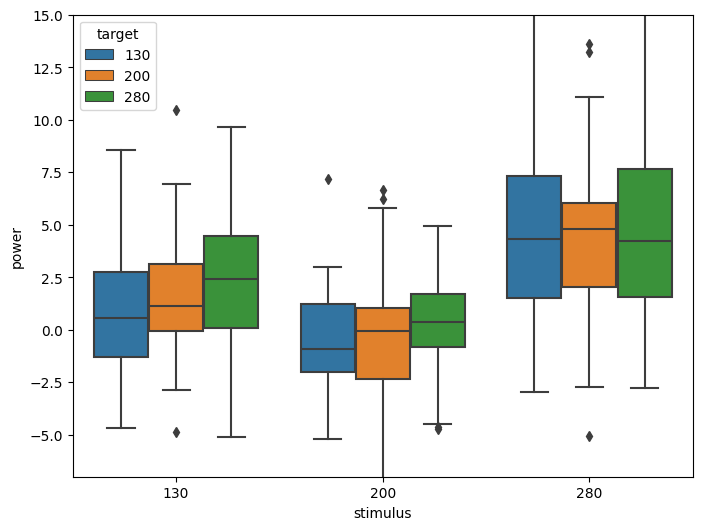

In [67]:
tmp = power_f0[(power_f0.frequency < 280) & (power_f0.frequency > 278)]
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.boxplot(tmp, x = 'stimulus', y = 'power', hue = 'target', ax = ax)
graph.set_ylim(-7, 15)

In [42]:
# # Compute only power at f0
# subs = np.unique(spectrums['subject'])
# stimuli = [130, 200, 280]
# power_f0 = pd.DataFrame()

# for sub in subs:
#     for stim in stimuli:

#         # Get FFR for subject
#         sub_spectrums = spectrums_sub[(spectrums_sub['subject'] == sub) & (spectrums_sub['stimulus'] == stim)].reset_index(drop = True)
#         idx = np.abs(sub_spectrums.frequency - stim).argmin()
#         hz = sub_spectrums.frequency[idx]
#         print(hz)
#         sub_power_f0 = sub_spectrums[sub_spectrums.frequency == hz]

#         # # Concat to data frame
#         power_f0 = pd.concat([power_f0, sub_power_f0])
#         # break
#     break

# # power_f0 = power_f0.reset_index(drop = True)
# # power_f0.to_csv('power_f0.csv', index = False)
# # # power_f0 = pd.read_csv('power_f0.csv')
# power_f0

129.4605809128631
199.1701244813278
278.8381742738589


,subject,stimulus,frequency,target,power
78,3,130,129.460581,130,2.126778
79,3,130,129.460581,200,7.821449
80,3,130,129.460581,280,6.387437
120,3,200,199.170124,130,13.404860
121,3,200,199.170124,200,14.143326
122,3,200,199.170124,280,11.441815
168,3,280,278.838174,130,9.459043
169,3,280,278.838174,200,5.922180
170,3,280,278.838174,280,7.561676


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

formula = 'power ~ C(stimulus) + C(target) + C(stimulus):C(target)'
model = ols(formula, data = power_f0).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

# Perform the Tukey HSD post-hoc test if the ANOVA results are significant
if any(p < 0.05 for p in anova_table['PR(>F)'][:-1]):
    m_comp = pairwise_tukeyhsd(power_f0.power, 
                              power_f0[[factor for factor in ['stimulus', 'target'] if factor in power_f0]].apply(lambda x: '-'.join(x.astype(str)), axis=1), 
                              alpha=0.05)
    print(m_comp)
else:
    print("No significant effect found, post-hoc test not performed.")

                            sum_sq     df          F        PR(>F)
C(stimulus)              10.363658    2.0   0.432032  6.495164e-01
C(target)               193.772585    2.0   8.077844  3.685227e-04
C(stimulus):C(target)   975.015060    4.0  20.322843  3.821069e-15
Residual               4425.814828  369.0        NaN           NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
130-130 130-200  -1.6988  0.377  -4.057  0.6593  False
130-130 130-280   0.2509    1.0 -2.1073   2.609  False
130-130 200-130  -1.5157 0.5405 -3.8738  0.8425  False
130-130 200-200   1.9973 0.1727 -0.3608  4.3555  False
130-130 200-280  -1.6971 0.3785 -4.0552  0.6611  False
130-130 280-130  -1.8981 0.2298 -4.2562  0.4601  False
130-130 280-200  -1.6542 0.4151 -4.0124  0.7039  False
130-130 280-280   3.2549 0.0007  0.8968  5.6131   True
130-200 130-280   1.9497 0.1987 -0.4084  4.3079  False
130-2

In [15]:
from scipy import stats

# 130 Hz
print('------- 130 Hz --------')
power_f0_130 = power_f0[power_f0.stimulus == 130]
f_statistic, p_value = stats.f_oneway(power_f0_130[power_f0_130.target == 130].power,
                                      power_f0_130[power_f0_130.target == 200].power,
                                      power_f0_130[power_f0_130.target == 280].power)
print(f_statistic, p_value)
m_comp = pairwise_tukeyhsd(power_f0_130['power'], power_f0_130['target'], alpha=0.05)
print(m_comp)

# 200 Hz
print('------- 200 Hz --------')
power_f0_200 = power_f0[power_f0.stimulus == 200]
f_statistic, p_value = stats.f_oneway(power_f0_200[power_f0_200.target == 200].power,
                                      power_f0_200[power_f0_200.target == 200].power,
                                      power_f0_200[power_f0_200.target == 280].power)
print(f_statistic, p_value)
m_comp = pairwise_tukeyhsd(power_f0_200['power'], power_f0_200['target'], alpha=0.05)
print(m_comp)

# 280 Hz
print('------- 280 Hz --------')
power_f0_280 = power_f0[power_f0.stimulus == 280]
f_statistic, p_value = stats.f_oneway(power_f0_280[power_f0_280.target == 130].power,
                                      power_f0_280[power_f0_280.target == 200].power,
                                      power_f0_280[power_f0_280.target == 280].power)
print(f_statistic, p_value)
m_comp = pairwise_tukeyhsd(power_f0_280['power'], power_f0_280['target'], alpha=0.05)
print(m_comp)

------- 130 Hz --------
5.242278412683083 0.0065336577384891474
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   130    200  -1.6988 0.0286 -3.2531 -0.1445   True
   130    280   0.2509 0.9224 -1.3034  1.8052  False
   200    280   1.9497 0.0098  0.3954   3.504   True
----------------------------------------------------
------- 200 Hz --------
11.229036826376902 3.3173225384761157e-05
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   130    200    3.513    0.0  1.8325  5.1934   True
   130    280  -0.1814 0.9645 -1.8619   1.499  False
   200    280  -3.6944    0.0 -5.3748 -2.0139   True
----------------------------------------------------
------- 280 Hz --------
21.602893945055587 9.108073631530833e-09
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 grou